In [1]:
import datetime
%load_ext autoreload
%autoreload 2

In [1]:
from njit_funcs_recursive_grid import *
from backtest import backtest
from plotting import plot_fills
from downloader import Downloader
from pure_funcs import (
    denumpyize,
    numpyize,
    candidate_to_live_config,
    calc_spans,
    analyze_fills,
    create_xk,
    round_dynamic,
    round_values,
    sort_dict_keys,
)
from procedures import (
    dump_live_config,
    load_live_config,
    add_argparse_args,
    prepare_backtest_config,
    make_get_filepath,
)
from time import time
import sys
import argparse
import pprint
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np

using numba
using numba


In [2]:
plt.rcParams["figure.figsize"] = [16, 9]
plt.rcParams["figure.facecolor"] = "w"
pd.set_option("display.precision", 10)

In [3]:
class Args:
    def __init__(self):
        self.backtest_config_path = "configs/backtest/default.hjson"
        self.exchange = "binance"
        self.symbol = "ADAUSDT"
        self.market_type = "futures"
        self.user = "binance_01"
        self.start_date = "2021-08-01"
        self.end_date = "2022-02-18"
        self.starting_balance = 10000.0
        self.starting_configs = ""
        self.base_dir = "backtests"


config = await prepare_backtest_config(Args())
dl = Downloader(config)
sts = time()
data = await dl.get_sampled_ticks()
timestamps = data[:, 0]
qtys = data[:, 1]
prices = data[:, 2]
config["n_days"] = (timestamps[-1] - timestamps[0]) / (1000 * 60 * 60 * 24)

print(f"millis to load {len(prices)} ticks {(time() - sts) * 1000:.0f}ms")

fetching market_specific_settings...
linear perpetual
2022-02-20T09:28:06  Loading cached tick data from backtests\binance\ADAUSDT\caches\2021-08-01_2022-02-18_ticks_cache.npy 
millis to load 17366400 ticks 170ms


<AxesSubplot:title={'center':'Coin Price'}, xlabel='Time', ylabel='Price'>

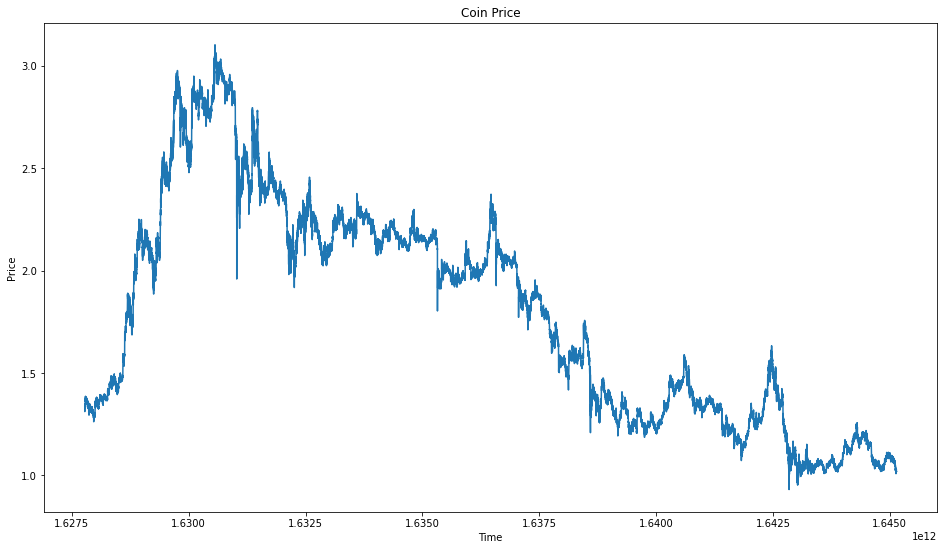

In [4]:
df = pd.DataFrame({"timestamp": timestamps, "qty": qtys, "price": prices}).set_index("timestamp")
df.price.iloc[::100].plot(title="Coin Price", xlabel="Time", ylabel="Price")

In [5]:
# choose a slice on which to test
wsize_days = 365
ts = int(data[-1][0] - 60 * 60 * 24 * 1000 * wsize_days)
idx = np.argmax(data[:, 0] >= ts)
dataslice = data[idx:]

In [27]:
with open('./cfgs_live/ADA.json') as json_file:
    hand_tuned = json.load(json_file)

config_to_test = {**config, **hand_tuned}


Grid Span Long = 92.05%
Grid Span Short = 107.12%


,qty,price,type,psize,pprice,wallet_exposure,eprice_pprice_diff,ddown_factor,bkr_price
3,-265.0,2.1112,short_rentry,-613.0,1.6308300163,0.09996988,0.2275340961,0.7614942529,17.9440437194
2,-179.0,1.4234,short_rentry,-348.0,1.2650310345,0.04402308,0.1112610408,1.0591715976,30.0006632184
1,-87.0,1.1708,short_rentry,-169.0,1.0972911243,0.01854422,0.0627851689,1.0609756098,60.2688887574
0,-82.0,1.0193,short_ientry_normal,-82.0,1.0193000000,0.00835826,0.0000000000,NaN,122.9705195122
0,89.0,1.0187,long_ientry_normal,89.0,1.0187000000,0.00906643,0.0000000000,NaN,0.0000000000
1,99.0,0.8958,long_rentry,188.0,0.9539813830,0.01793485,0.0649490768,1.1123595506,0.0000000000
2,210.0,0.7607,long_rentry,398.0,0.8519987437,0.03390955,0.1200193818,1.1170212766,0.0000000000
3,444.0,0.5537,long_rentry,842.0,0.6947010689,0.05849383,0.2546524632,1.1155778894,0.0000000000
4,940.0,0.2937,long_rentry,1782.0,0.4831741302,0.08610163,0.6451281246,1.1163895487,0.0000000000
5,1716.0,0.0810,long_rentry,3498.0,0.2858811607,0.10000123,2.5293970452,0.9629629630,0.0000000000


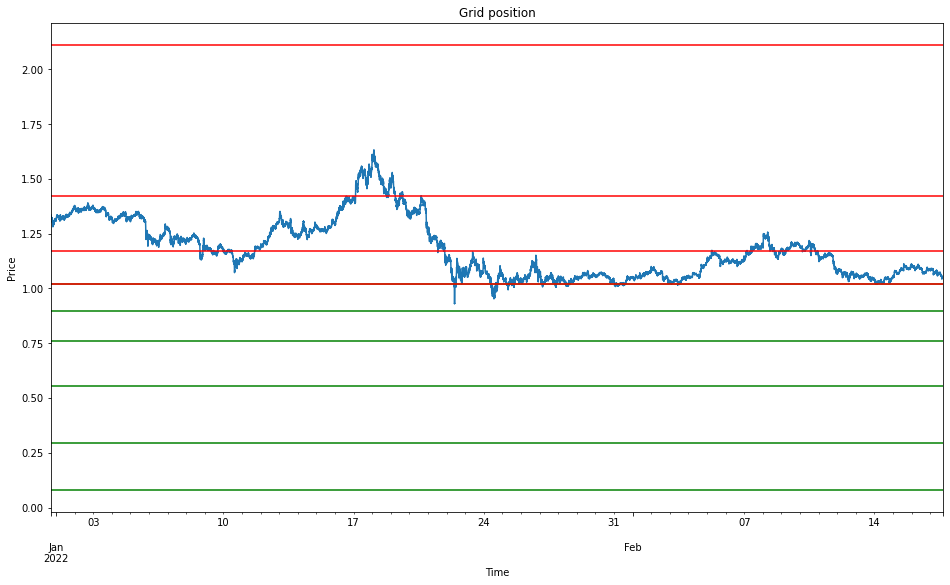

In [50]:
import datetime


config_to_test['long']['initial_eprice_ema_dist'] = 0.0005

grid_long = calc_recursive_entries_long(
    Args().starting_balance,
    0.0,
    0.0,
    df.price.iloc[-1],
    df.price.iloc[-1],
    config_to_test["inverse"],
    config_to_test["qty_step"],
    config_to_test["price_step"],
    config_to_test["min_qty"],
    config_to_test["min_cost"],
    config_to_test["c_mult"],
    config_to_test["long"]["initial_qty_pct"],
    config_to_test["long"]["initial_eprice_ema_dist"],
    config_to_test["long"]["ddown_factor"],
    config_to_test["long"]["rentry_pprice_dist"],
    config_to_test["long"]["rentry_pprice_dist_wallet_exposure_weighting"],
    config_to_test["long"]["wallet_exposure_limit"],
    config_to_test["long"]["auto_unstuck_ema_dist"],
    config_to_test["long"]["auto_unstuck_wallet_exposure_threshold"],
    whole_grid=True,
)

grid_short = calc_recursive_entries_short(
    Args().starting_balance,
    0.0,
    0.0,
    df.price.iloc[-1],
    df.price.iloc[-1],
    config_to_test["inverse"],
    config_to_test["qty_step"],
    config_to_test["price_step"],
    config_to_test["min_qty"],
    config_to_test["min_cost"],
    config_to_test["c_mult"],
    config_to_test["short"]["initial_qty_pct"],
    config_to_test["short"]["initial_eprice_ema_dist"],
    config_to_test["short"]["ddown_factor"],
    config_to_test["short"]["rentry_pprice_dist"],
    config_to_test["short"]["rentry_pprice_dist_wallet_exposure_weighting"],
    config_to_test["short"]["wallet_exposure_limit"],
    config_to_test["short"]["auto_unstuck_ema_dist"],
    config_to_test["short"]["auto_unstuck_wallet_exposure_threshold"],
    whole_grid=True,
)

gdf_long = pd.DataFrame(
    grid_long, columns=["qty", "price", "type", "psize", "pprice", "wallet_exposure"]
)
gdf_long.loc[:, "eprice_pprice_diff"] = abs(gdf_long.price - gdf_long.pprice) / gdf_long.price
gdf_long.loc[:, "ddown_factor"] = gdf_long.qty / gdf_long.psize.shift()
gdf_long.loc[:, "bkr_price"] = gdf_long.apply(
    lambda x: calc_bankruptcy_price(
        Args().starting_balance,
        x.psize,
        x.pprice,
        0.0,
        0.0,
        config_to_test["inverse"],
        config_to_test["c_mult"],
    ),
    axis=1,
)
gdf_short = pd.DataFrame(
    grid_short, columns=["qty", "price", "type", "psize", "pprice", "wallet_exposure"]
)
gdf_short.loc[:, "eprice_pprice_diff"] = abs(gdf_short.price - gdf_short.pprice) / gdf_short.price
gdf_short.loc[:, "ddown_factor"] = gdf_short.qty / gdf_short.psize.shift()
gdf_short.loc[:, "bkr_price"] = gdf_short.apply(
    lambda x: calc_bankruptcy_price(
        Args().starting_balance,
        x.psize,
        x.pprice,
        0.0,
        0.0,
        config_to_test["inverse"],
        config_to_test["c_mult"],
    ),
    axis=1,
)

# Display grid on graph
from_date = datetime.datetime(year=2022,month=1,day=1).timestamp()*1000
to_date = datetime.datetime(year=2022,month=2,day=18).timestamp()*1000

from_tick = np.where(timestamps == from_date)[0][0]
to_tick = np.where(timestamps == to_date)[0][0]
# n_ticks = to_date - from_date

#n_ticks = 60 * 60 * 24 * 45  # 14 days

dfx = pd.DataFrame(
    {
        "timestamp": pd.to_datetime(timestamps[from_tick:to_tick], unit="ms"),
        "qty": qtys[from_tick:to_tick],
        "price": prices[from_tick:to_tick],
    }
).set_index("timestamp")
lastdayfrom = pd.to_datetime(Args().end_date)
# lastdayfrom = pd.Timestamp('2021-05-21')
fig = (
    dfx.price.loc[lastdayfrom - pd.Timedelta(days=280) : lastdayfrom]
    .iloc[::100]
    .plot(title="Grid position", xlabel="Time", ylabel="Price")
)
if config_to_test["long"]["enabled"]:
    for i, e in enumerate(gdf_long.itertuples()):
        fig.axhline(y=e.price, color="g", linestyle="-")
    print(f"\nGrid Span Long = {-(gdf_long.price.iloc[-1] / gdf_long.price.iloc[0] - 1) * 100:.2f}%")

if config_to_test["short"]["enabled"]:
    for i, e in enumerate(gdf_short.itertuples()):
        fig.axhline(y=e.price, color="r", linestyle="-")
    print(f"Grid Span Short = {(gdf_short.price.iloc[-1] / gdf_short.price.iloc[0] - 1) * 100:.2f}%")

pd.concat([gdf_long, gdf_short]).sort_values("price", ascending=False)

In [31]:
sts = time()
fills_long, fills_short, stats = backtest(config_to_test, dataslice)
elapsed = time() - sts
print(f"seconds elapsed {elapsed:.4f}")
longs, shorts, sdf, analysis = analyze_fills(fills_long, fills_short, stats, config_to_test)
pprint.pprint(analysis)

seconds elapsed 40.9728
{'DGstd_long': 0.0015595620464103448,
 'DGstd_short': 0.0026216438296440617,
 'adg_DGstd_ratio_long': 0.028277896374275028,
 'adg_DGstd_ratio_short': 0.04819029565498703,
 'adg_long': 4.410113393764403e-05,
 'adg_per_exposure_long': 0.0004410113393764403,
 'adg_per_exposure_short': 0.0012633779125261978,
 'adg_short': 0.0001263377912526198,
 'avg_fills_per_day_long': 1.696523274334143,
 'avg_fills_per_day_short': 2.6019990395212806,
 'biggest_psize_long': 389.0,
 'biggest_psize_quote_long': 596.0118,
 'biggest_psize_quote_short': 999.0834531268264,
 'biggest_psize_short': 435.0,
 'closest_bkr_long': 1.0,
 'closest_bkr_short': 1.0,
 'eqbal_ratio_mean_long': 0.996818347748088,
 'eqbal_ratio_mean_short': 0.997088479020679,
 'eqbal_ratio_min_long': 0.9823356904519362,
 'eqbal_ratio_min_short': 0.9649269380473737,
 'exchange': 'binance',
 'fee_sum_long': -1.31115248,
 'fee_sum_short': -2.6947725200000003,
 'final_balance_long': 10157.713247520016,
 'final_balance_sho

In [32]:
sdf

,timestamp,bkr_price_long,bkr_price_short,psize_long,pprice_long,psize_short,pprice_short,price,closest_bkr_long,closest_bkr_short,balance_long,balance_short,equity_long,equity_short,wallet_exposure_long,wallet_exposure_short
0,1627776000000.0,0.0,0.0000000000,0.0,0.0000000000,0.0,0.0000000000,1.3187,1.0,1.0,10000.00000000,10000.0000000000,10000.00000000,10000.00000000,0.00000000,0.0000000000
1,1627776060000.0,0.0,0.0000000000,0.0,0.0000000000,0.0,0.0000000000,1.3187,1.0,1.0,10000.00000000,10000.0000000000,10000.00000000,10000.00000000,0.00000000,0.0000000000
2,1627776120000.0,0.0,0.0000000000,0.0,0.0000000000,0.0,0.0000000000,1.3145,1.0,1.0,10000.00000000,10000.0000000000,10000.00000000,10000.00000000,0.00000000,0.0000000000
3,1627776180000.0,0.0,0.0000000000,0.0,0.0000000000,0.0,0.0000000000,1.3117,1.0,1.0,10000.00000000,10000.0000000000,10000.00000000,10000.00000000,0.00000000,0.0000000000
4,1627776240000.0,0.0,0.0000000000,0.0,0.0000000000,0.0,0.0000000000,1.3130,1.0,1.0,10000.00000000,10000.0000000000,10000.00000000,10000.00000000,0.00000000,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289435,1645142100000.0,0.0,151.7397915806,265.0,1.2990369811,-68.0,1.0392208212,1.0189,1.0,1.0,10157.71324752,10247.6388116356,10083.47694752,10249.02062748,0.03388999,0.0068959316
289436,1645142160000.0,0.0,151.7397915806,265.0,1.2990369811,-68.0,1.0392208212,1.0181,1.0,1.0,10157.71324752,10247.6388116356,10083.26494752,10249.07502748,0.03388999,0.0068959316
289437,1645142220000.0,0.0,151.7397915806,265.0,1.2990369811,-68.0,1.0392208212,1.0170,1.0,1.0,10157.71324752,10247.6388116356,10082.97344752,10249.14982748,0.03388999,0.0068959316
289438,1645142280000.0,0.0,151.7397915806,265.0,1.2990369811,-68.0,1.0392208212,1.0185,1.0,1.0,10157.71324752,10247.6388116356,10083.37094752,10249.04782748,0.03388999,0.0068959316


<AxesSubplot:title={'center':'Balance and equity long'}, xlabel='Time', ylabel='Balance'>

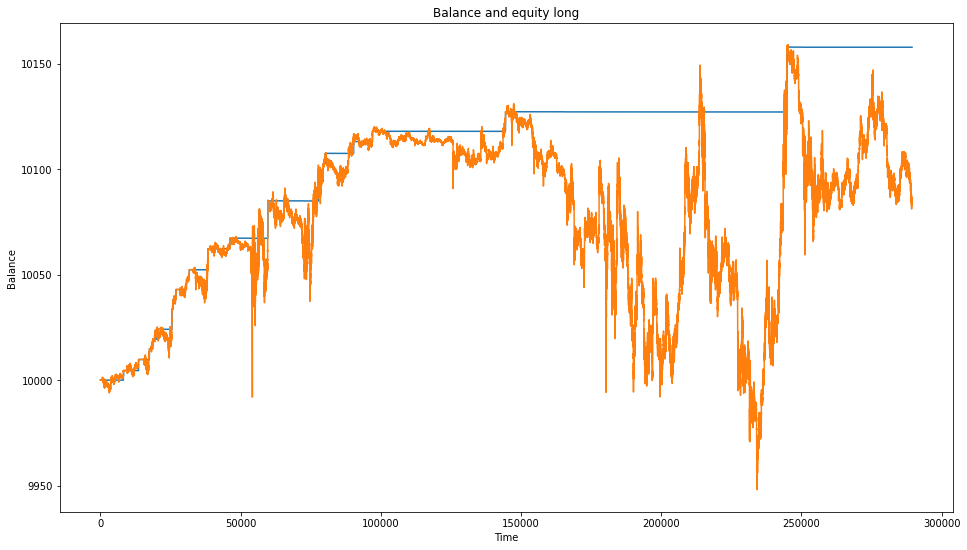

In [33]:
sdf.balance_long.plot()
sdf.equity_long.plot(title="Balance and equity long", xlabel="Time", ylabel="Balance")

<AxesSubplot:title={'center':'Balance and equity short'}, xlabel='Time', ylabel='Balance'>

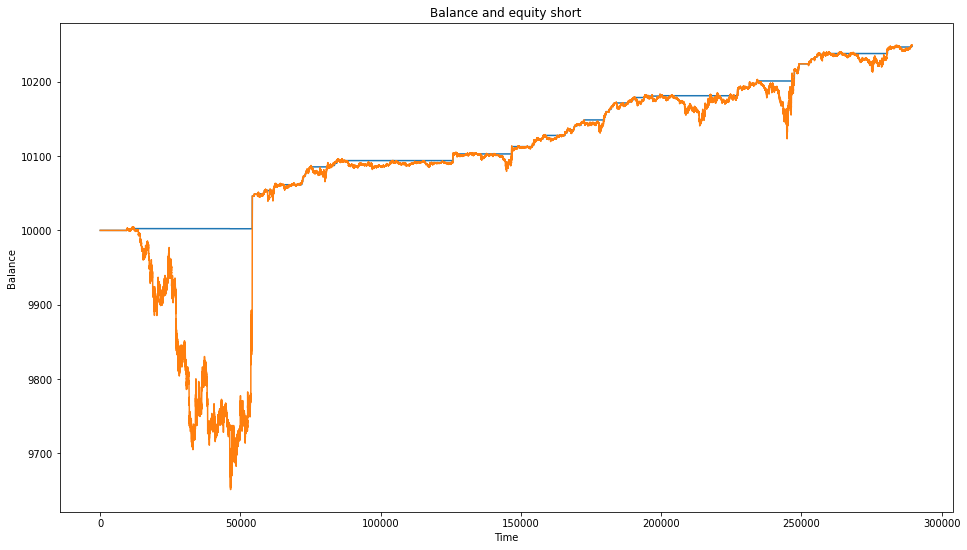

In [34]:
sdf.balance_short.plot()
sdf.equity_short.plot(title="Balance and equity short", xlabel="Time", ylabel="Balance")

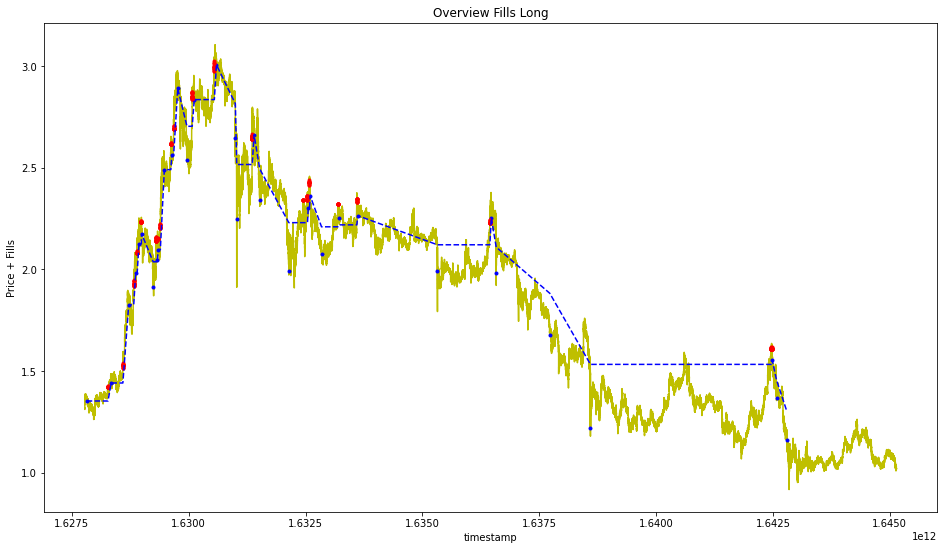

In [35]:
if len(longs) > 0:
    plot_fills(df, longs, plot_whole_df=True, title="Overview Fills Long")

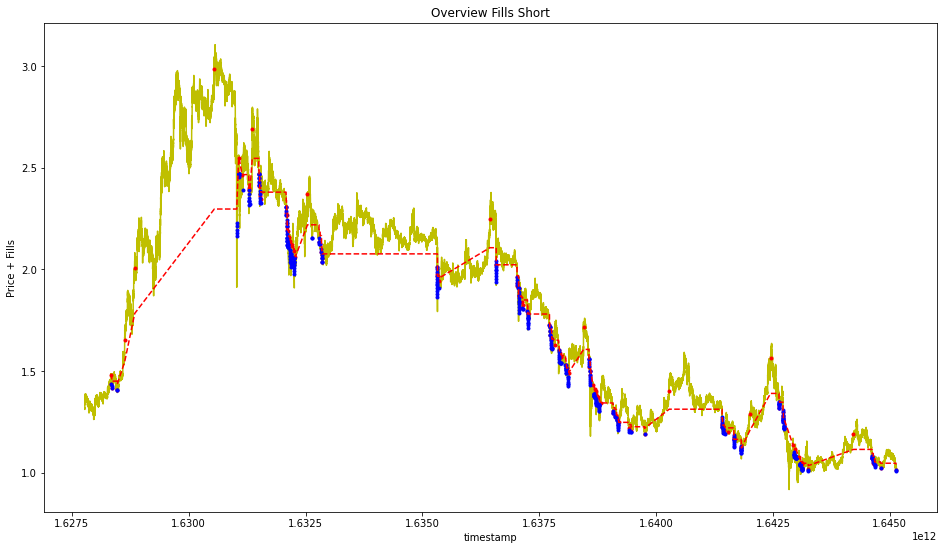

In [36]:
if len(shorts) > 0:
    plot_fills(df, shorts, plot_whole_df=True, title="Overview Fills Short")

<AxesSubplot:title={'center':'Position size in terms of contracts'}, xlabel='Time', ylabel='Long Position size'>

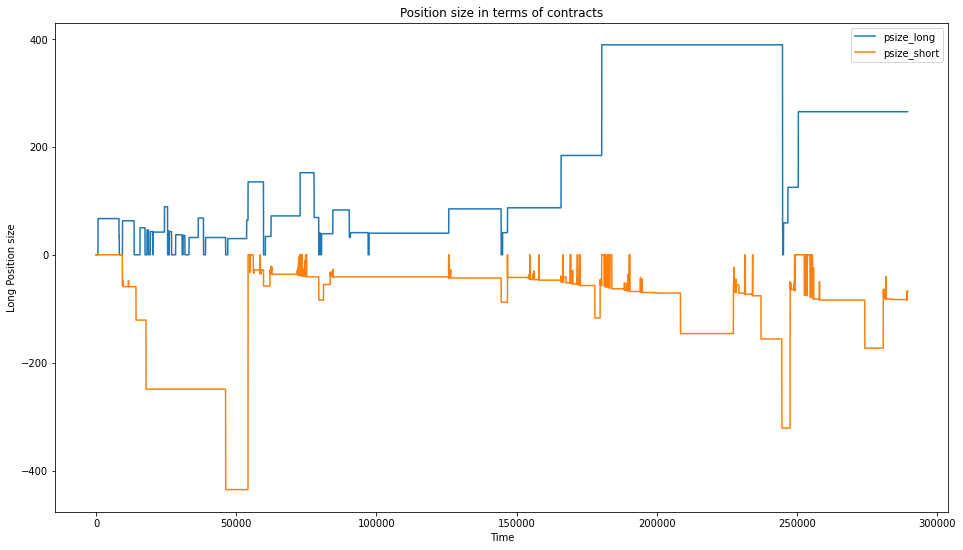

In [37]:
sdf[["psize_long", "psize_short"]].plot(
    title="Position size in terms of contracts", xlabel="Time", ylabel="Long Position size"
)

<AxesSubplot:title={'center':'Average entry price'}, xlabel='Time', ylabel='Price'>

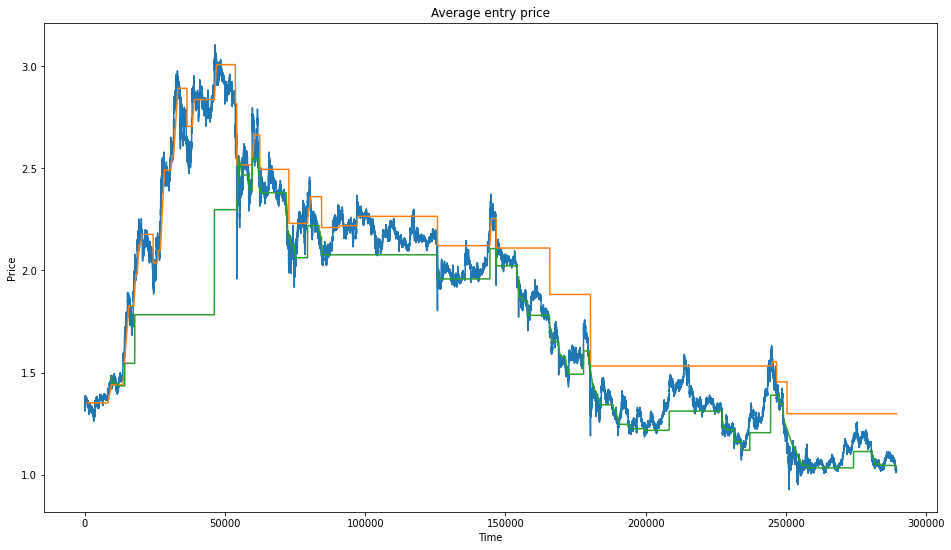

In [38]:
sdf.price.plot(title="Average entry price", xlabel="Time", ylabel="Price")
sdf[sdf.psize_long != 0].pprice_long.replace(0.0, np.nan).plot()
sdf[sdf.psize_short != 0].pprice_short.replace(0.0, np.nan).plot()

Price action distance long mean 0.103838 std 0.086433


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

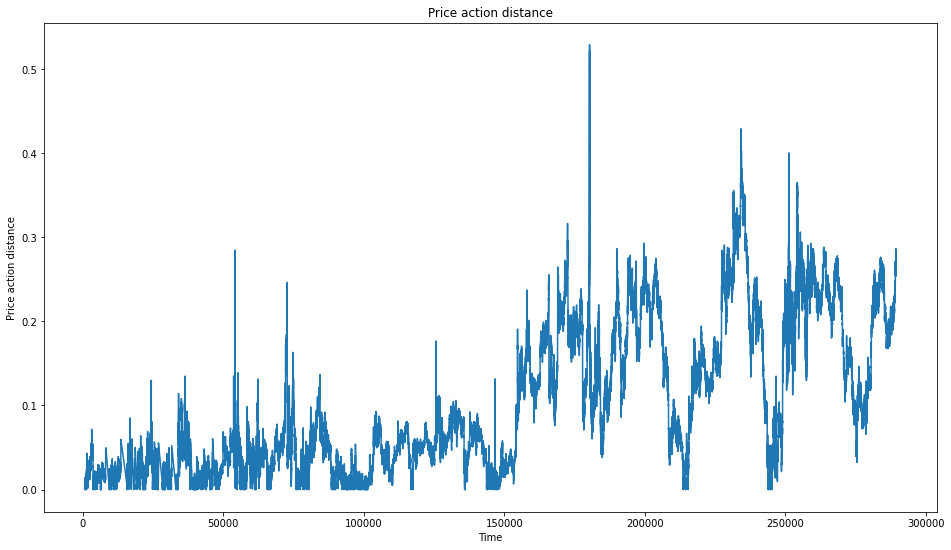

In [39]:
lpprices = sdf[sdf.psize_long != 0.0]
PADistance_long = (lpprices.pprice_long - lpprices.price).abs() / lpprices.price
print(f"Price action distance long mean {PADistance_long.mean():.6f} std {PADistance_long.std():.6f}")
PADistance_long.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

Mean price action distance short 0.069612


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

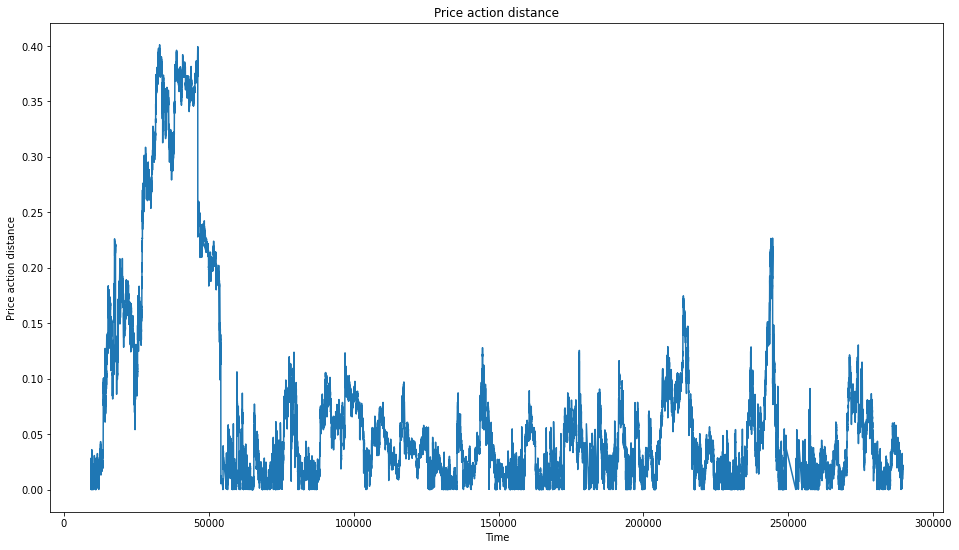

In [40]:
spprices = sdf[sdf.psize_short != 0.0]
PADistance_short = (spprices.pprice_short - spprices.price).abs() / spprices.price
print(f"Mean price action distance short {PADistance_short.mean():.6f}")
PADistance_short.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

spans in minutes [683.3991701131126, 659.4616228940063, 636.3625405017917] n_days 201.0


<AxesSubplot:title={'center':'Unstucking Bands and Initial Entry Band'}, xlabel='timestamp'>

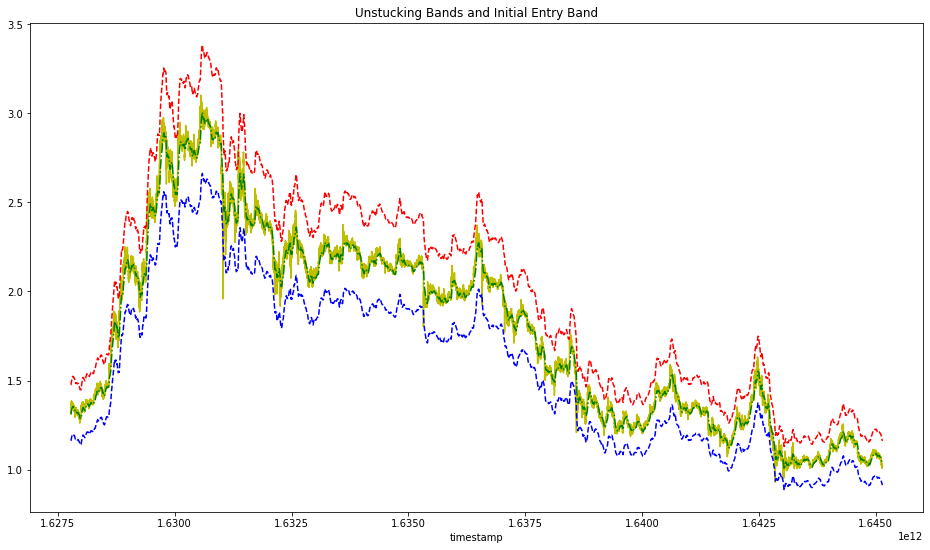

In [41]:
# Inspect long EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["long"]["ema_span_0"],
    (config_to_test["long"]["ema_span_0"] * config_to_test["long"]["ema_span_1"]) ** 0.5,
    config_to_test["long"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * 60)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["long"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["long"]["auto_unstuck_ema_dist"])
long_ientry_band = ema_band_lower * (1 - config_to_test["long"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(
    style="b--",
)
unstucking_band_upper.iloc[::100].plot(style="r--")
long_ientry_band.iloc[::100].plot(style="g-.")

spans in minutes [9368.25305774036, 4772.353806285345, 2431.1214387562322] n_days 201.0


<AxesSubplot:title={'center':'Unstucking Bands and Initial Entry Band'}, xlabel='timestamp'>

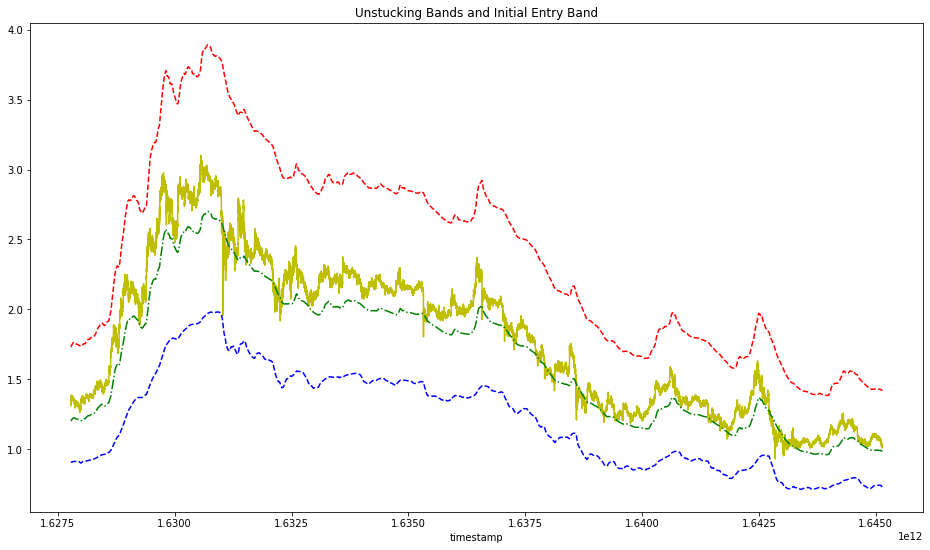

In [42]:
# Inspect short EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["short"]["ema_span_0"],
    (config_to_test["short"]["ema_span_0"] * config_to_test["short"]["ema_span_1"]) ** 0.5,
    config_to_test["short"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * 60)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["short"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["short"]["auto_unstuck_ema_dist"])
short_ientry_band = ema_band_upper * (1 + config_to_test["short"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(style="b--")
unstucking_band_upper.iloc[::100].plot(style="r--")
short_ientry_band.iloc[::100].plot(style="g-.")